# <center>Predicting hydrogen storage capacity of metal-organic frameworks by  
# <center>multi-linear regression and neural network



# <center>Analysis Report

<center>Xudong Zhuang

# Outline of this notebook

### Part 1. Exploratory Data Analysis
**1.1 Data Information**

**1.2 Data Cleaning**

**1.3 Data Visulization**

**1.4 Data Normalization**

**1.5 Feature Importance Identification**

### Part 2. Multi-linear Regression
**2.1 Model 1: Predicting UV by MLR**

**2.2 Model 2: Predicting UG by MLR**

### Part 3. Neural Network

# Part 1. Exploratory Data Analysis (EDA)

In [64]:
# import some packages
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [65]:
# read in the data
data = pd.read_csv('ps_usable_hydrogen_storage_capacity_gcmcv2.csv')

## 1.1 Data Information
This dataset contains 98,694 different MOFs with 7 structural properties and usable gravimetric storage capacity (UG) and usable volumetric storage capacity (UV) of each MOF. Herein, UG and UV are the storage capacity differences between 1 and 100 bar at 77 K. The structural properties are the input parameters and UG/UV are the responses of all the investigated models.

7 Structural properties,  2 responses and their units in this dataset are provided as follows:

Property | unit
--- | ---
Density | $$g/cm^3$$
Gravimetric surface area (GSA) | $$m^2/g$$
Volumetric surface area (VSA) | $$m^2/cm^3$$
Void fraction (VF)| 
Pore volume (PV)| $$cm^3/g$$
Largest cavity diameter (LCD) | $$Å$$
Pore limiting diameter (PLD) | $$Å$$
Usable gravimetric storage capacity (UG) | $$wt.\%$$
Usable volumetric storage capacity (UV) | $$g/L$$

## 1. 2 Data Cleaning

In [66]:
# check the size of the loaded data 
assert(data.shape[0] == 98694)
assert(data.shape[1] == 17)

### Step 1. Column name modifications

It was found that the column names of the original dataset has an extra space at the end. To make later coding more convenient, the extra spaces were dropped and some long column names were also modified. 

In [67]:
data = data.rename(columns=lambda x: x.rstrip()) # delete the extra space at the end and check it again
data = data.rename(columns={'UG at PS':'UG', 'UV at PS': 'UV'}) # simplify some column names

### Step 2. Abnormal data removal

This step was conducted in order to remove those structures whose structural properties are smaller or equal to 0. For those structures with structural properties that are smaller than 0, it can be due to some collection error. For those structures with structural properties that are equal to 0, it is unlikely that they can perform well in hydrogen adsorption and this condition is unlikely to occur in experimental synthesized MOFs. So it is safe to remove them.

In [68]:
# remove data whose features are smaller or equal to 0
features_name = data.columns[5:14].tolist()
for feature in features_name:
    data = data.drop(data[data[feature] <= 0].index)

### Step 3. Check missing values

Check if there's any NaN values remained in the filtered dataset. These NaN values can lead to error for the following analysis and modeling. However, tt was found that no NaN value remained.

In [69]:
def check_nan(col, data):
    '''Count the number of nan for a specific column in a dataset.'''
    return data.shape[0] - data[col].dropna().size

def print_nan(features, data):
    '''Print nan for original_training_data'''
    for feature in features:
        print('  Nan of ' + str(feature) + ': ' + str(check_nan(feature, data)))

print_nan(features_name, data)

  Nan of Density: 0
  Nan of GSA: 0
  Nan of VSA: 0
  Nan of VF: 0
  Nan of PV: 0
  Nan of LCD: 0
  Nan of PLD: 0
  Nan of UG: 0
  Nan of UV: 0


After data cleaning, the shape of data contains 88,426 rows.

In [70]:
data.shape

(88426, 17)

## 1.3 Data Visulization

### Step 1.  Distributions of single features and UG/UV

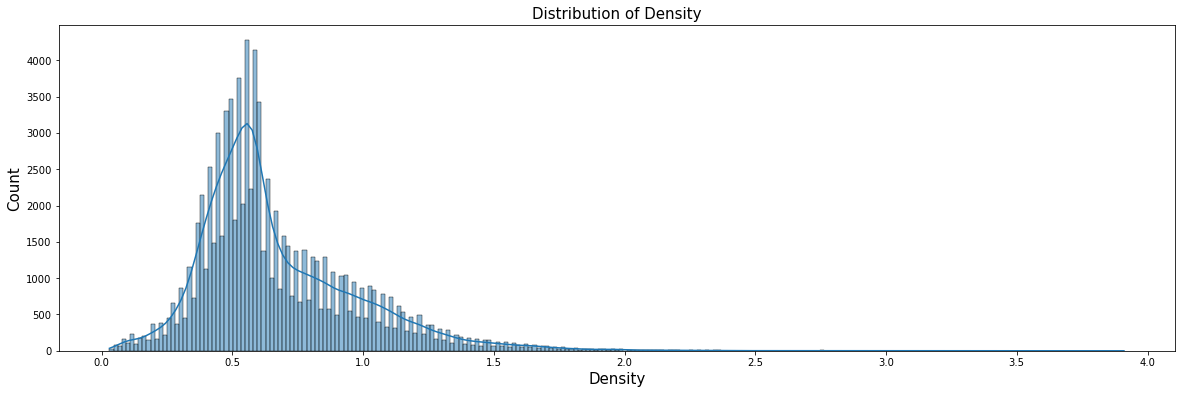

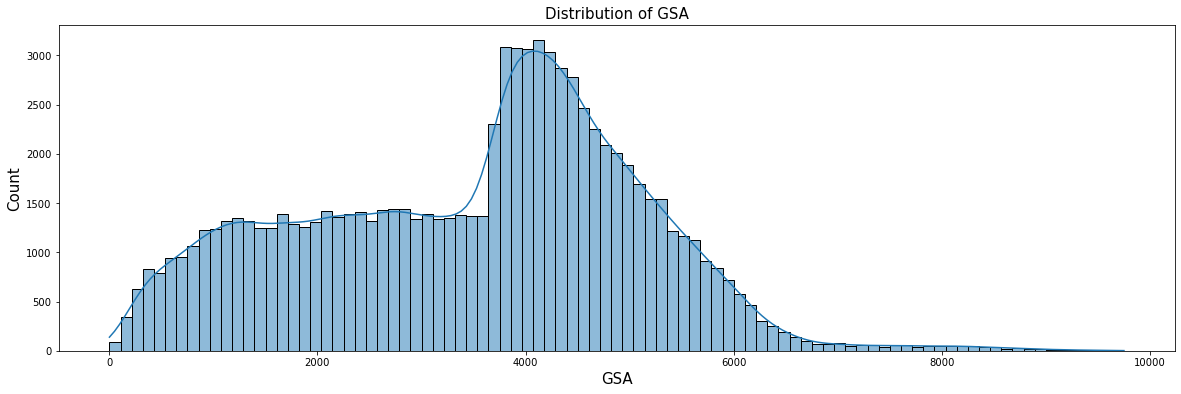

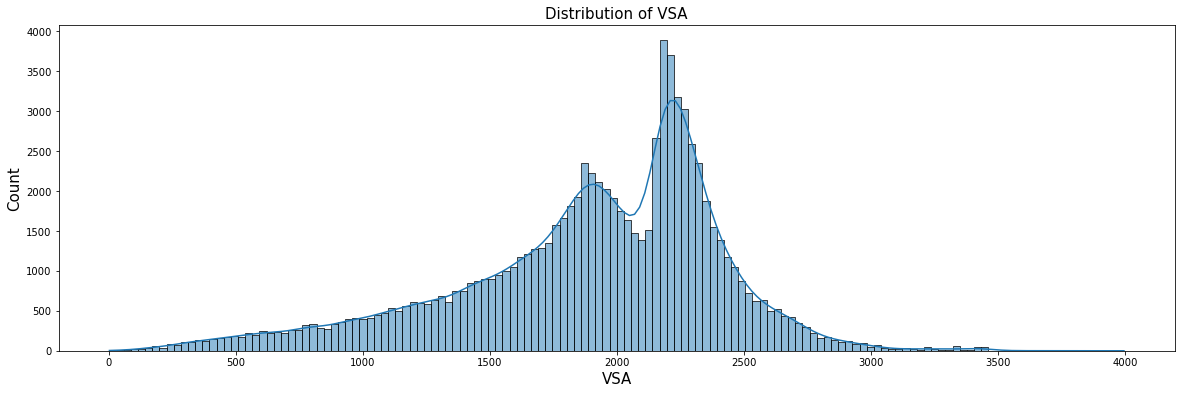

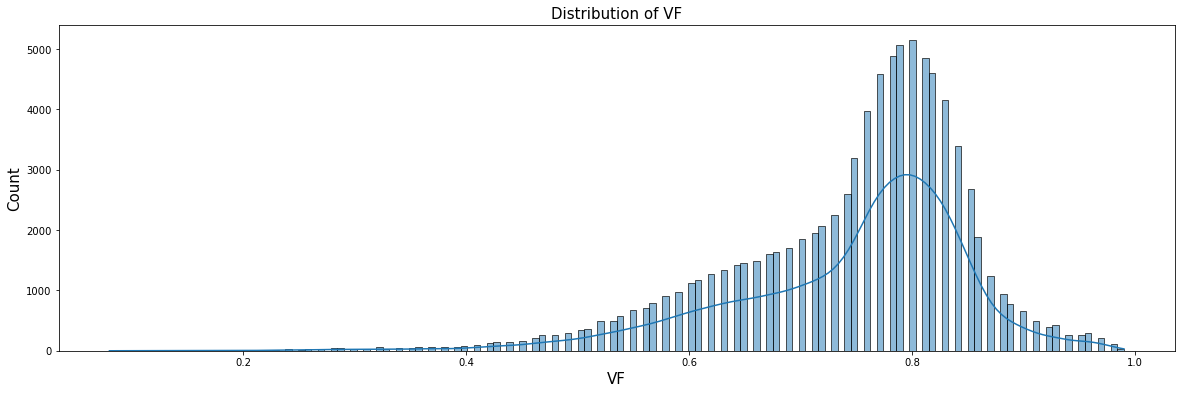

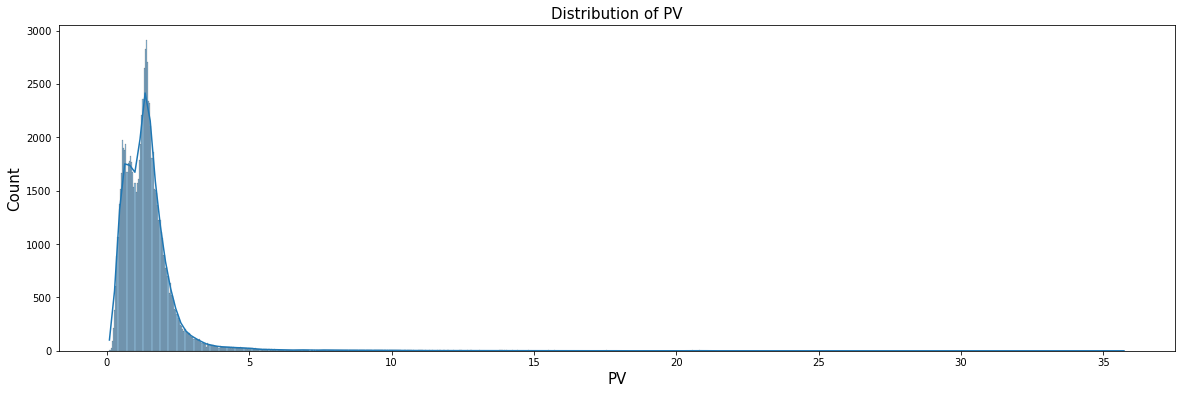

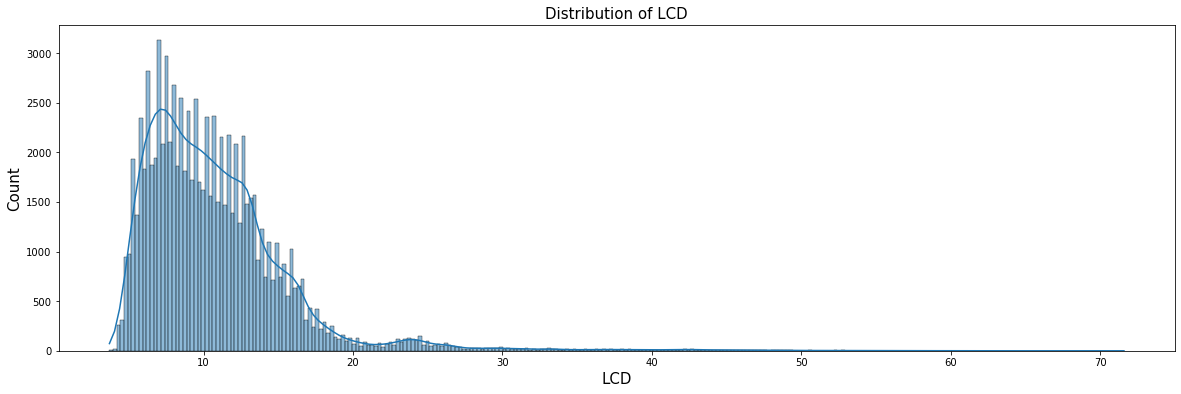

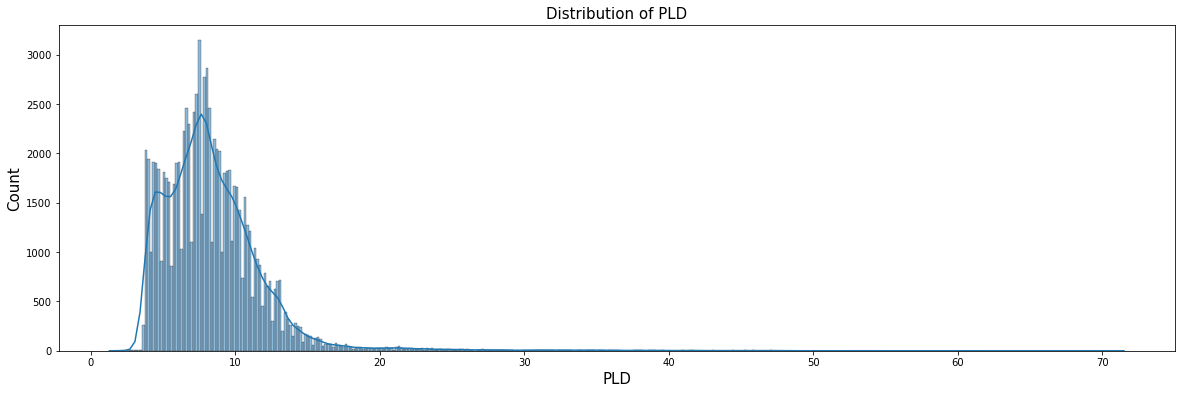

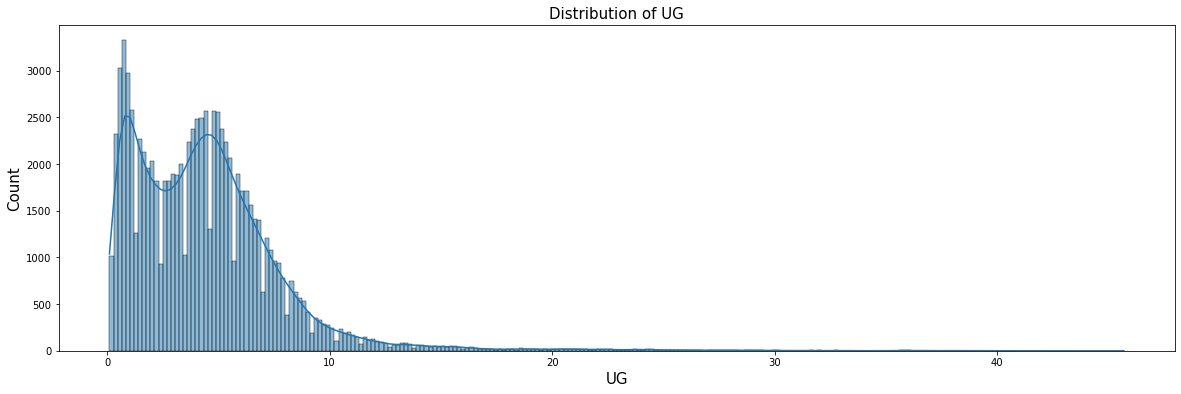

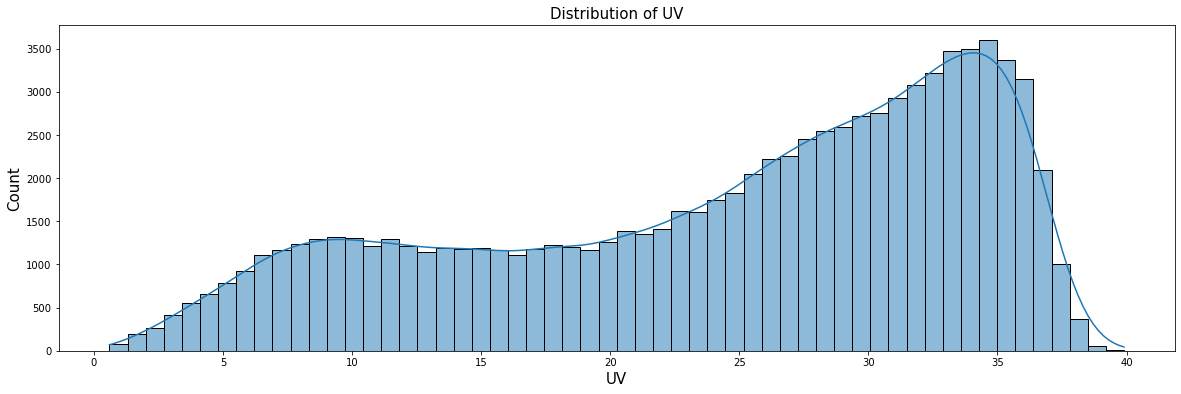

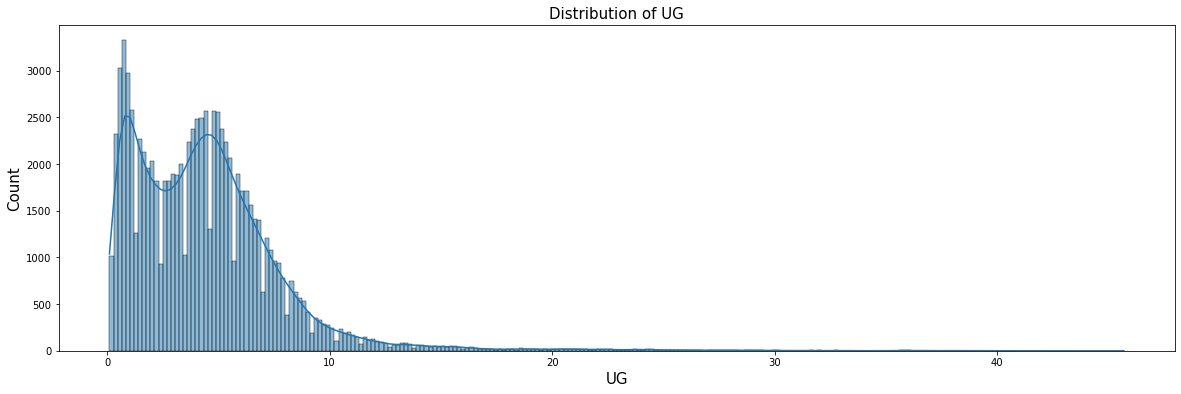

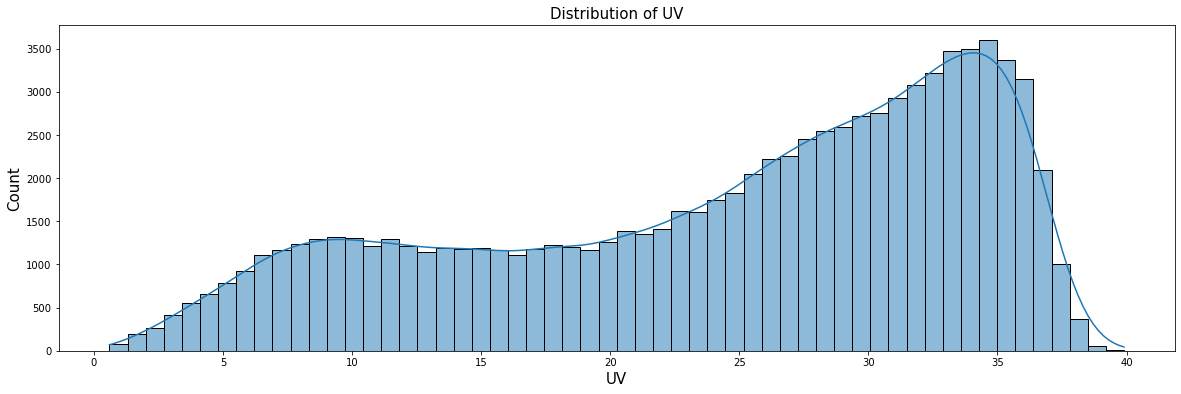

In [71]:
def plot_dist(data, var_names):
    '''Plot the distribution of each variable.'''
    for var in var_names:
        plt.figure(figsize=(20, 6))
        sns.histplot(data[var], kde = True)
        plt.title('Distribution of '+str(var), fontsize = 15)
        plt.xlabel(var, fontsize = 15)
        plt.ylabel('Count', fontsize = 15)
        
features_name.append('UG')
features_name.append('UV')
plot_dist(data, features_name)

From the above visulizations, one can observe that the distributions of different features and responses are extremely different and they have different ranges.

### Step 3. Relationships between pairs of features and responses.
1. Relationship between responses:

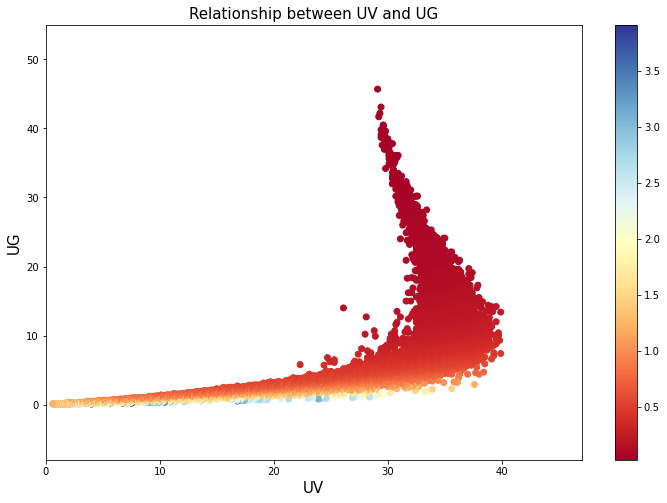

In [72]:
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(12, 8))
plt.scatter(data['UV'], data['UG'], c = data['Density'], cmap = cm)
plt.title('Relationship between UV and UG', fontsize = 15)
plt.xlabel('UV', fontsize = 15)
plt.xlim(0, 47)
plt.ylabel('UG', fontsize = 15)
plt.ylim(-8, 55)
plt.colorbar()
plt.show()

In [73]:
r1 = np.corrcoef(data['UV'],data['UG'])[0][1]
r1

0.7610752854028975

It was found that the linear correlation between the two reponses is not as high as expected, which is shown in the plot above as well as the correlation coefficient. Points with relatively high UG and low UV occur in the dataset. Actually, this is related to the low density of these structures, which is shown in the colorbar on the right side of this plot.

2. Relationships between structural properties and UG/UV:

From the above analysis, it can be anticipated that the difference of density may reduce the linear relationship between each pair of structural property and response. To investigate the influence of density, colorbar was added on the right side of each plot except the density/UG and density/UV plot.

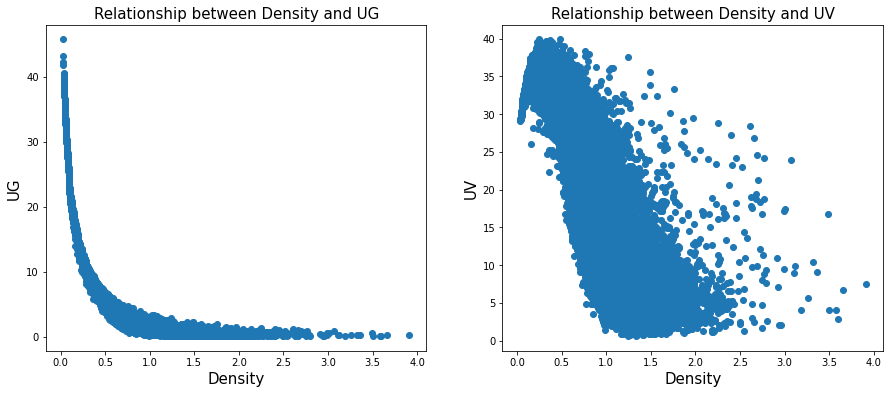

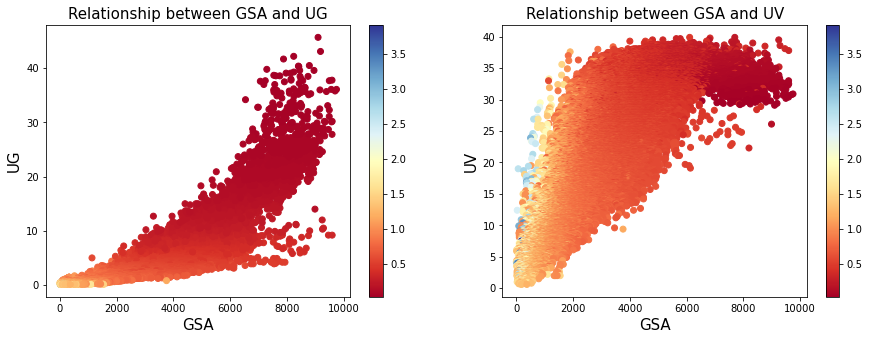

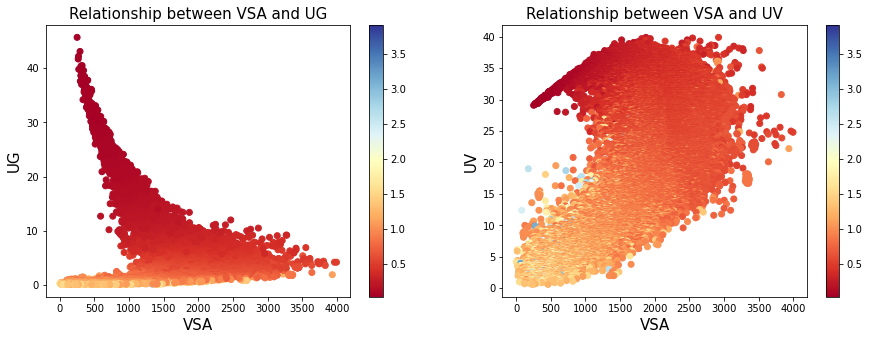

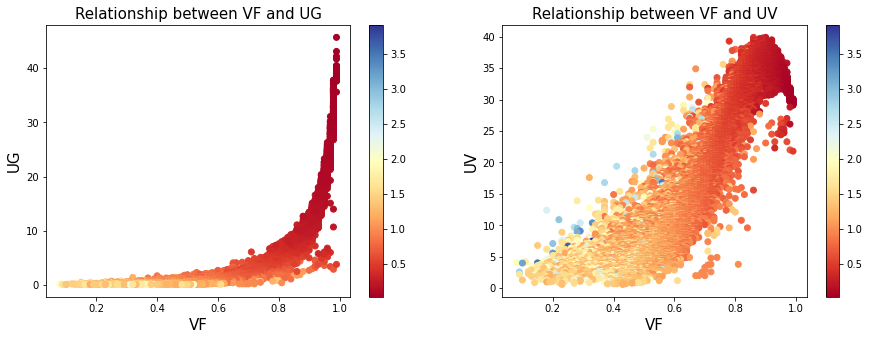

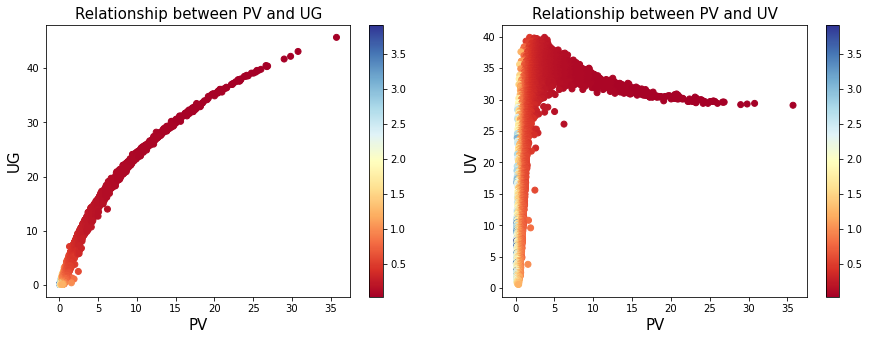

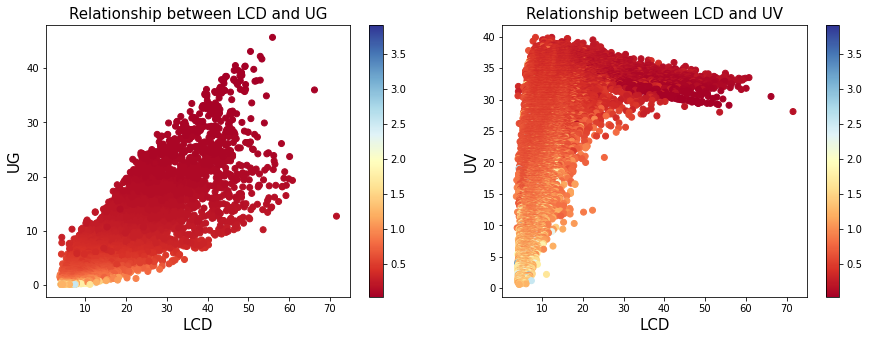

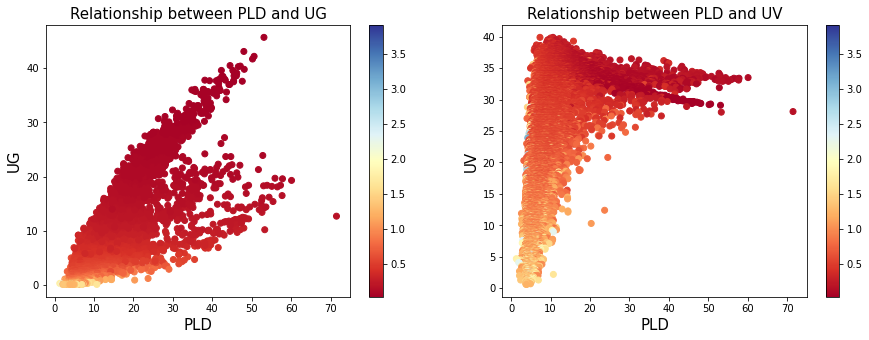

In [74]:
def single_feature_plot(data, single_feature):
    '''Plot the relationship between single feature and UG/UV'''
    
    # check that the input single_feature has type of str
    try:
        assert(type(single_feature) == str)
    except:
        raise TypeError('The input single_feature is not string.')

    if single_feature == 'Density':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
        ax1.scatter(data[single_feature], data['UG'])
        ax1.set_xlabel(single_feature, fontsize = 15)
        ax1.set_ylabel('UG',fontsize = 15)
        ax1.set_title('Relationship between '+single_feature+ ' and UG', fontsize = 15)
        ax2.scatter(data[single_feature], data['UV'])
        ax2.set_xlabel(single_feature, fontsize = 15)
        ax2.set_ylabel('UV', fontsize = 15)
        ax2.set_title('Relationship between '+single_feature+ ' and UV', fontsize = 15)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
        sc1 = ax1.scatter(data[single_feature], data['UG'], c = data['Density'], cmap = cm)
        ax1.set_xlabel(single_feature, fontsize = 15)
        ax1.set_ylabel('UG',fontsize = 15)
        ax1.set_title('Relationship between '+single_feature+ ' and UG', fontsize = 15)
        fig.colorbar(sc1, ax = ax1)
        sc2 = ax2.scatter(data[single_feature], data['UV'], c = data['Density'], cmap = cm)
        ax2.set_xlabel(single_feature, fontsize = 15)
        ax2.set_ylabel('UV', fontsize = 15)
        ax2.set_title('Relationship between '+single_feature+ ' and UV', fontsize = 15)
        fig.colorbar(sc2, ax = ax2)

for single_feature in features_name[:7]:
    single_feature_plot(data, single_feature)

**Optimal values of features**

Optimal values of investigated features were summerized as follows:

Property | UG | UV
--- | --- | ---
Density | ~0 | ~0.5 
GSA | ~9000 | 4000-9000
VSA | ~500 | 1500-2000
VF| ~1.0 | ~0.9
PV| ~35 | ~4
LCD | ~55 | ~10
PLD | ~55 | ~10

From the above ploting, 3 conclusions can be made:
1. The relationships between same feature and UV/UG can be greatly different. This point make it difficult to strengthen the linear relationships between a feature and UV/UG simultaneously.
1. Some of the relationships are far from linear, and this may be due to the occurance of low density structures. One of the representitive one is the relationship between VSA and UG. This relationship is far from linear, which is due to the existance of low VSA but high UG. This is due to the existance of low density structures.
1. LCD and PLD share similar distribution, which may suggest the strong linear relationship between each other. This may be used to simplify the model. To identify this assumption, the relationship between PLD and LCD was plotted below.

<Figure size 864x576 with 0 Axes>

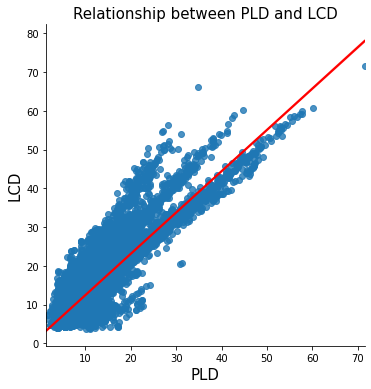

In [75]:
plt.figure(figsize=(12, 8))
sns.lmplot(x = 'PLD', y = 'LCD', data = data, line_kws={'color': 'red'})
plt.title('Relationship between PLD and LCD', fontsize = 15)
plt.xlabel('PLD', fontsize = 15)
plt.ylabel('LCD', fontsize = 15)
plt.show()

In [76]:
r2 = np.corrcoef(data['PLD'],data['LCD'])[0][1]
r2

0.8079178915610999

From the above plotting and calculation, it was found that the PLD and LCD doesn't have a very strong linear relationship as expected. Therefore, adding LCD and PLD simultaneously may still help to improve the model accuracy.

## 1.4 Data Normalization

Data normalization sometimes can be useful to improve the performance of the model. To figure out this issue, data normalization is conducted in order to make comparison between to the model that is trained by raw data and normalized data.

In [77]:
features_name = ['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']

In [78]:
from sklearn import preprocessing
normed_features = preprocessing.normalize(data[features_name])
normed_data = pd.DataFrame(data = normed_features, columns = features_name)
normed_data['UV'] = data['UV'].to_numpy()
normed_data['UG'] = data['UG'].to_numpy()
normed_data

,Density,GSA,VSA,VF,PV,LCD,PLD,UV,UG
0,0.000030,0.971680,0.236293,0.000114,0.000470,0.001565,0.001338,39.9,13.4
1,0.000071,0.902203,0.431309,0.000127,0.000266,0.001241,0.001078,39.9,7.4
2,0.000051,0.937008,0.349302,0.000122,0.000328,0.001565,0.001373,39.8,9.3
3,0.000054,0.952067,0.305871,0.000149,0.000464,0.002736,0.001841,39.7,10.4
4,0.000054,0.948217,0.317604,0.000146,0.000428,0.002675,0.002002,39.7,10.0
...,...,...,...,...,...,...,...,...,...
88421,0.008926,0.599483,0.799311,0.002731,0.002065,0.031972,0.024645,0.7,0.1
88422,0.003844,0.620515,0.783967,0.001332,0.001029,0.013621,0.012410,0.7,0.1
88423,0.005132,0.578684,0.815252,0.001456,0.001019,0.016378,0.013830,0.7,0.1
88424,0.004508,0.599877,0.799836,0.000780,0.001118,0.014912,0.012879,0.6,0.1


In [79]:
# Check that the data is cleaned
print_nan(['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD', 'UV', 'UG'], normed_data)

  Nan of Density: 0
  Nan of GSA: 0
  Nan of VSA: 0
  Nan of VF: 0
  Nan of PV: 0
  Nan of LCD: 0
  Nan of PLD: 0
  Nan of UV: 0
  Nan of UG: 0


## 1.5 Feature Importance Identification

The purpose of doing this step is to prepare for the simplification of models by dropping some features that is not so important. Therefore, drop-column importance was used to identify the importnace of each feature. 

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

In [81]:
# pipeline of fitting the basic model
def basic_model(features_name, res, data):
    '''Define the basic model and return the matrices'''
    train, test = train_test_split(data, train_size = 0.9, random_state=42)
    model = lr().fit(train[features_name], train[res])

    r2_train = model.score(train[features_name], train[res])
    r2_test = model.score(test[features_name], test[res])

    mse_train = mean_squared_error(train[res], model.predict(train[features_name]), squared = False)
    mse_test = mean_squared_error(test[res], model.predict(test[features_name]), squared = False)
    
    matrices = np.array([[r2_train, r2_test], [mse_train, mse_test]])
    return [model, pd.DataFrame(data = matrices, index = ['r2', 'MSE'], columns = ['train', 'test'])]

### Step 1. Define the basic models for UV and UG

In [82]:
# Baseline model for UV
baseline_model_UV, baseline_matrices_UV = basic_model(features_name, 'UV', normed_data)
baseline_matrices_UV

,train,test
r2,0.836053,0.830093
MSE,3.903351,3.939299


In [83]:
# Baseline model for UV
baseline_model_UV_raw, baseline_matrices_UV_raw = basic_model(features_name, 'UV', data)
baseline_matrices_UV_raw

,train,test
r2,0.908602,0.898767
MSE,2.914438,3.040705


In [84]:
# Baseline model for UG
baseline_model_UG, baseline_matrices_UG = basic_model(features_name, 'UG', normed_data)
baseline_matrices_UG

,train,test
r2,0.966060,0.967149
MSE,0.646545,0.653830


In [85]:
# Baseline model for UG
baseline_model_UG_raw, baseline_matrices_UG_raw = basic_model(features_name, 'UG', data)
baseline_matrices_UG_raw

,train,test
r2,0.988602,0.988380
MSE,0.374680,0.388868


It turns out that the data without normalization performs better for predicting two reponses by linear regression. Therefore, for the following modeling proecess of linear regression, the data without normalization will be used.

In [86]:
def drop_column(features_name, res, baseline_matrices):
    '''Calculate the importance of each feature'''
    diffs = []
    for i in range(len(features_name)):
        feature = features_name[i]
        features_name.remove(features_name[i])
        _, matrices = basic_model(features_name, res, data)
        r2 = matrices.loc['r2', 'test']
        r2_base = baseline_matrices.loc['r2', 'test']
        mse = matrices.loc['MSE', 'test']
        mse_base = baseline_matrices.loc['MSE', 'test']
        diffs.append(np.array([r2_base - r2, mse - mse_base]))
        features_name.insert(i, feature)
    return pd.DataFrame(data = diffs, index = features_name, columns = ['r2_diff', 'mse_diff'])

### Step 2. Calculate the importance of each feature for predicting UV by drop-column importance

In [87]:
features_name = ['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']

In [88]:
diffs_UV = drop_column(features_name, 'UV', baseline_matrices_UV_raw)
display(diffs_UV)

imp_UV_r2 = diffs_UV.sort_values(by = 'r2_diff', ascending = False).index.tolist()
print('Importance of feature sorted by difference of r2: ')
print(imp_UV_r2)

imp_UV_mse = diffs_UV.sort_values(by = 'mse_diff', ascending = False).index.tolist()
print('Importance of feature sorted by difference of mse: ')
print(imp_UV_mse)

,r2_diff,mse_diff
Density,0.000467,0.007008
GSA,0.025867,0.366400
VSA,0.000061,0.000919
VF,0.041752,0.573052
PV,0.025079,0.355822
LCD,0.004215,0.062657
PLD,0.000953,0.014282


Importance of feature sorted by difference of r2: 
['VF', 'GSA', 'PV', 'LCD', 'PLD', 'Density', 'VSA']
Importance of feature sorted by difference of mse: 
['VF', 'GSA', 'PV', 'LCD', 'PLD', 'Density', 'VSA']


From the above investigation, we can find that the importance of feature for predicting **UV** sorted by r2 and mse has the same sequence, that is:

**VF > GSA > PV > LCD > PLD > Density > VSA**

### Step 3. Calculate the importance of each feature for predicting UG by drop-column importance

In [89]:
diffs_UG = drop_column(features_name, 'UG', baseline_matrices_UG_raw)
display(diffs_UG)

imp_UG_r2 = diffs_UG.sort_values(by = 'r2_diff', ascending = False).index.tolist()
print('Importance of feature sorted by difference of r2: ')
print(imp_UG_r2)

imp_UG_mse = diffs_UG.sort_values(by = 'mse_diff', ascending = False).index.tolist()
print('Importance of feature sorted by difference of mse: ')
print(imp_UG_mse)

,r2_diff,mse_diff
Density,0.001347,0.021913
GSA,0.032889,0.372187
VSA,0.021828,0.270881
VF,0.006175,0.092351
PV,0.032570,0.369456
LCD,0.001346,0.021898
PLD,0.000042,0.000707


Importance of feature sorted by difference of r2: 
['GSA', 'PV', 'VSA', 'VF', 'Density', 'LCD', 'PLD']
Importance of feature sorted by difference of mse: 
['GSA', 'PV', 'VSA', 'VF', 'Density', 'LCD', 'PLD']


From the above investigation, we can find that the importance of feature for predicting **UG** sorted by r2 and mse has the same sequence, that is:

**GSA > PV > VSA > VF > Density > LCD > PLD**

# Part 2. Muti-Linear Regression (MLR)

**2.1 Model 1: Predicting UV by MLR**

**2.2 Model 2: Predicting UG by MLR**

### Optimization steps of MLR models for predicting UV or UG
Step 1. Data Transformation

Step 2. Feature Tunning

Step 3. Regularization

Step 4. Optimal train/test ratio

Step 5. Cross Validation

Step 6. Optimized Model Investigation

## 2.1 Model 1: Predicting UV by MLR

### Step 1. Data Transformation

In [90]:
# calculating the correlation coefficient to prepare for data transformation evaluation
corr_coefs = []
for single_feature in features_name[:7]:
    corr_coefs.append([np.corrcoef(data[single_feature],data['UV'])[0][1],np.corrcoef(data[single_feature],data['UG'])[0][1]])

df_rs = pd.DataFrame(columns =['UV', 'UG'], data = corr_coefs, index = features_name[:7])
df_rs

,UV,UG
Density,-0.859583,-0.767001
GSA,0.879612,0.832184
VSA,0.531110,0.082389
VF,0.931427,0.793706
PV,0.531742,0.933681
LCD,0.598184,0.828274
PLD,0.616528,0.825909


In [91]:
# create an empty list to store the transformed average correlation coefficients
transformed_corrs = []

# Density
data_trans = data.copy()
data_trans['Density'] = -data_trans['Density']**0.6
val1 = np.corrcoef(data_trans['Density'],data['UV'])[0][1]
transformed_corrs.append(val1)

# GSA
data_trans['GSA'] = data_trans['GSA']**0.7
val2 = np.corrcoef(data_trans['GSA'],data['UV'])[0][1]
transformed_corrs.append(val2)

# VSA
data_trans['VSA'] = (data_trans['VSA'])**0.3
val3 = np.corrcoef(data_trans['VSA'],data['UV'])[0][1]
transformed_corrs.append(val3)

# VF
data_trans['VF'] = (data_trans['VF'])**2.1
val4 = np.corrcoef(data_trans['VF'],data['UV'])[0][1]
transformed_corrs.append(val4)

# PV
data_trans['PV'] = (data_trans['PV'])**0.1
val5 = np.corrcoef(data_trans['PV'],data['UV'])[0][1]
transformed_corrs.append(val5)

# LCD
data_trans['LCD'] = np.log(data_trans['LCD'])
val6 = np.corrcoef(data_trans['LCD'],data['UV'])[0][1]
transformed_corrs.append(val6)

# PLD
data_trans['PLD'] = np.log(data_trans['PLD'])
val7 = np.corrcoef(data_trans['PLD'],data['UV'])[0][1]
transformed_corrs.append(val7)

In [92]:
df_rs['Transformed_UV_corr'] = transformed_corrs
df_rs

,UV,UG,Transformed_UV_corr
Density,-0.859583,-0.767001,0.873311
GSA,0.879612,0.832184,0.894125
VSA,0.531110,0.082389,0.548980
VF,0.931427,0.793706,0.944659
PV,0.531742,0.933681,0.867419
LCD,0.598184,0.828274,0.727839
PLD,0.616528,0.825909,0.789985


### Step 2. Tunning the features
* Can the transformed data help to improve the performance of MLR model?
* What is the best combination of features?

In [93]:
# Pipeline for tunning the features
def func_certain_features_single(features_name, data, res, method):
    
    train, test = train_test_split(data, train_size = 0.9, random_state=42)
    model = method.fit(train[features_name], train[res])
    
    r2_train = model.score(train[features_name], train[res])
    r2_test = model.score(test[features_name], test[res])

    mse_train = mean_squared_error(train[res], model.predict(train[features_name]), squared = True)
    mse_test = mean_squared_error(test[res], model.predict(test[features_name]), squared = True)
    
    return [r2_train, r2_test, mse_train, mse_test]
    
def feature_tun_single(features, data, res, method):
    
    r2s_train = []
    r2s_test = []
    mses_train = []
    mses_test = []
    
    for i in range(1, len(features)+1):
        r2_train, r2_test, mse_train, mse_test = func_certain_features_single(features[:i], data, res, method)
        
        r2s_train.append(r2_train)
        r2s_test.append(r2_test)             
        
        mses_train.append(mse_train)
        mses_test.append(mse_test)
    
    return [r2s_train, r2s_test, mses_train, mses_test]

In [94]:
r2s_train, r2s_test, rmses_train, rmses_test = feature_tun_single(imp_UV_r2, data, 'UV', lr())
#print(rmses_test)

r2s_train_trans, r2s_test_trans, rmses_train_trans, rmses_test_trans = feature_tun_single(imp_UV_r2, data_trans, 'UV', lr())
#print(rmses_test_trans)

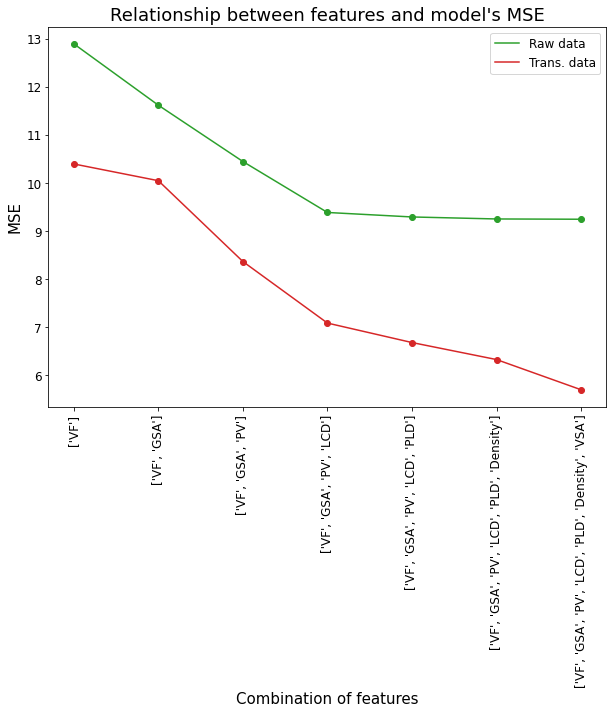

In [95]:
# get combinations of features
feature_comb = []
for i in range(1, len(imp_UV_r2)+1):
    feature_comb.append(imp_UV_r2[:i])

plt.figure(figsize = (10, 7))
plt.plot(np.linspace(1, 7, 7), rmses_test, color='tab:green')
plt.scatter(np.linspace(1, 7, 7), rmses_test, color='tab:green')
plt.plot(np.linspace(1, 7, 7), rmses_test_trans, color='tab:red')
plt.scatter(np.linspace(1, 7, 7), rmses_test_trans, color='tab:red')
plt.xlabel('Combination of features', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title("Relationship between features and model's MSE", fontsize = 18)
plt.legend(['Raw data', 'Trans. data'], fontsize = 12)
plt.xticks(np.linspace(1, 7, 7), feature_comb, rotation = 90, fontsize = 12)
plt.yticks(np.linspace(6, 13, 8), fontsize = 12)
plt.show()

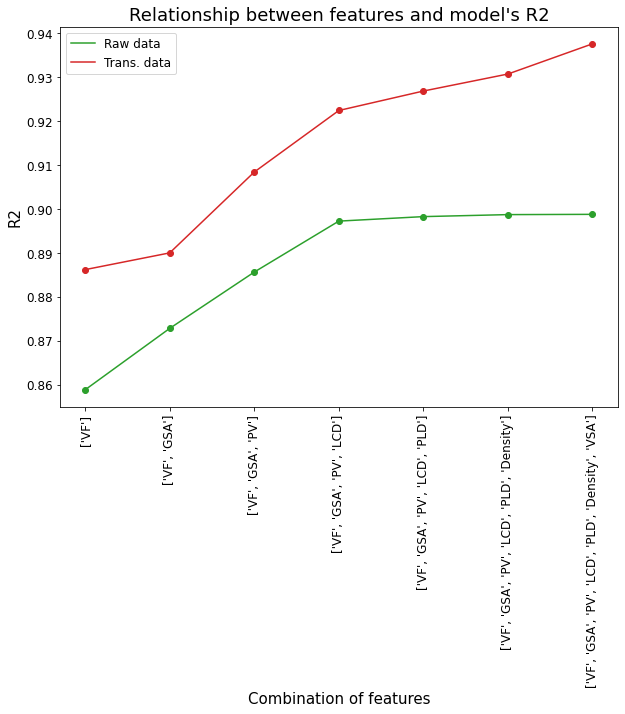

In [96]:
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(1, 7, 7), r2s_test, color='tab:green')
plt.scatter(np.linspace(1, 7, 7), r2s_test, color='tab:green')
plt.plot(np.linspace(1, 7, 7), r2s_test_trans, color='tab:red')
plt.scatter(np.linspace(1, 7, 7), r2s_test_trans, color='tab:red')
plt.xlabel('Combination of features', fontsize = 15)
plt.ylabel('R2', fontsize = 15)
plt.title("Relationship between features and model's R2", fontsize = 18)
plt.legend(['Raw data', 'Trans. data'], fontsize = 12)
plt.xticks(np.linspace(1, 7, 7), feature_comb, rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

From the 2 above plots, it can be concluded that transformed data can help enhance the performance of MLR model due to lower MSE score and higher R2 score. Although adding more features in the case of raw data may not help, but for the transformed data, all features should be added in order to achieve the best performance.

### Step 3. Regularization

In [97]:
def reg_method_single(data, method, res, features_name):
    '''Calculate matrices of certain regularization method for certain res'''
    train, test = train_test_split(data, train_size = 0.9, random_state=42)
    model = method.fit(train[features_name], train[res])

    r2_train = model.score(train[features_name], train[res])
    r2_test = model.score(test[features_name], test[res])

    mse_train = mean_squared_error(train[res], model.predict(train[features_name]), squared = True)
    mse_test = mean_squared_error(test[res], model.predict(test[features_name]), squared = True)
    
    return [r2_train, r2_test, mse_train, mse_test]

In [98]:
# linear regression
r2_train_lr, r2_test_lr, mse_train_lr, mse_test_lr = reg_method_single(data_trans, lr(), 'UV', features_name)

# Ridge
r2_train_R, r2_test_R, mse_train_R, mse_test_R = reg_method_single(data_trans, Ridge(), 'UV', features_name)

# Lasso
r2_train_L, r2_test_L, mse_train_L, mse_test_L = reg_method_single(data_trans, Lasso(), 'UV', features_name)

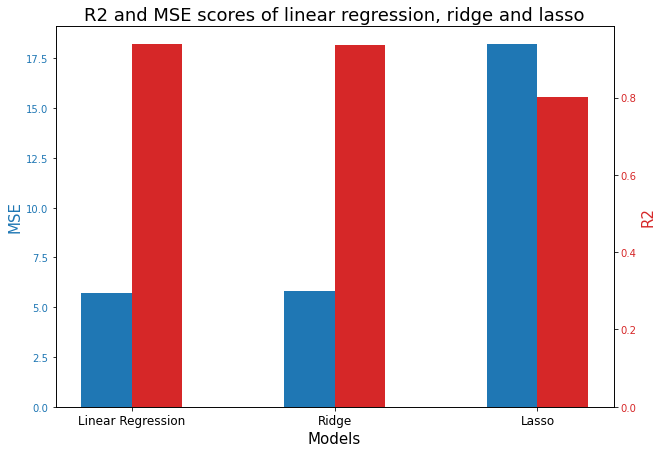

In [99]:
reg_r2_scores = [r2_test_lr, r2_test_R, r2_test_L]
reg_mse_scores = [mse_test_lr, mse_test_R, mse_test_L]
labels = ['Linear Regression', 'Ridge', 'Lasso']

x = np.arange(len(labels))
width = 0.25

fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.bar(x - width/2, reg_mse_scores, width, label='MSE', color = 'tab:blue')

ax1.set_ylabel('MSE', color = 'tab:blue', fontsize = 15)
ax1.set_title('R2 and MSE scores of linear regression, ridge and lasso', fontsize = 18)
ax1.set_xlabel('Models', fontsize = 15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize = 12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.bar(x + width/2, reg_r2_scores, width, label='R2', color = 'tab:red')
ax2.set_ylabel('R2', color = 'tab:red', fontsize = 15)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

The above analysis shows us that the linear regression and ridge model perform roughly the same while the lasso model performs much worse than the previous two models. **For the simplicity of the model, linear regression was selected.**

### Step 4. Optimal train/test ratio

In [100]:
assert(features_name == ['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD'])
train_test_ratios = np.linspace(0.1, 0.9, 9)

def optimal_ratio_single(features_name, data, res, method, train_test_ratios = np.linspace(0.1, 0.9, 9)):

    r2_trains = []
    r2_tests = []
    mse_trains = []
    mse_tests = []

    for ratio in train_test_ratios:
        train, test = train_test_split(data, train_size = ratio, random_state=42)
        model = method.fit(train[features_name], train[res])

        r2_trains.append(model.score(train[features_name], train[res]))
        r2_tests.append(model.score(test[features_name], test[res]))

        MSE_train = mean_squared_error(train[res], model.predict(train[features_name]), squared = True)
        mse_trains.append(MSE_train)
        MSE_test = mean_squared_error(test[res], model.predict(test[features_name]), squared = True)
        mse_tests.append(MSE_test)
    
    return [r2_trains, r2_tests, mse_trains, mse_tests]

In [101]:
r2_train, r2_test, mse_train, mse_test = optimal_ratio_single(features_name, data_trans, 'UV', lr())
print(max(r2_test))
print(min(mse_test))

0.939548987153706
5.581452448870569


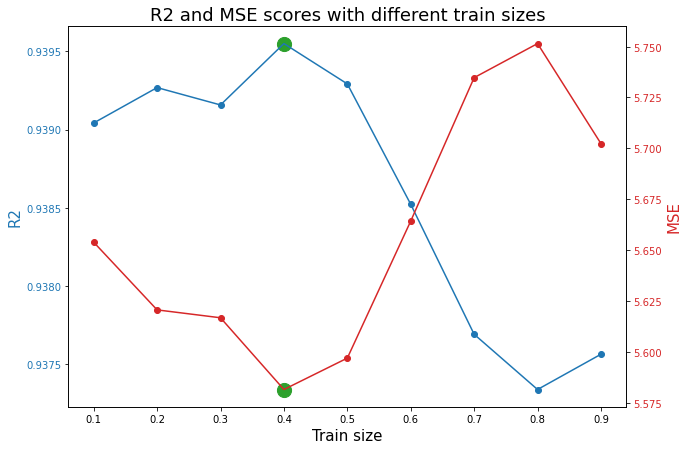

In [102]:
fig, ax1 = plt.subplots(figsize = (10, 7))

ax1.plot(train_test_ratios, r2_test, color = 'tab:blue')
ax1.scatter(train_test_ratios, r2_test, color = 'tab:blue')
plt.scatter(train_test_ratios[3], r2_test[3], color = 'tab:green', s = 200)
ax1.set_ylabel('R2', color = 'tab:blue', fontsize = 15)
ax1.set_title('R2 and MSE scores with different train sizes', fontsize = 18)
ax1.set_xlabel('Train size', fontsize = 15)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(train_test_ratios, mse_test, color = 'tab:red')
ax2.scatter(train_test_ratios, mse_test, color = 'tab:red')
plt.scatter(train_test_ratios[3], mse_test[3], color = 'tab:green', s = 200)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylabel('MSE', color = 'tab:red', fontsize = 15)
plt.show()

**The optimal train/test ratio for this model is 4/6 as the largest R2 score and the smallest mse score both occur at this ratio.**

### Step 5. Cross Validation

In [103]:
from sklearn.metrics import r2_score

def CV(method, res, data, features_name, size, fold_number = np.linspace(2, 10, 9)):
    ''' calculate the performance matrices with cross validation'''
    train, test = train_test_split(data, train_size = size, random_state=42) # optimal train_size = 0.4 is used
    mses = []
    r2s = []
    
    for fold in fold_number:
        
        # instantiate the spliter: turn off the shuffle in order to avoid randomness of k due to shuffling data
        # turn on to see the effect of cross validation
        kf = KFold(n_splits = int(fold), shuffle = False) 
        preds = []

        for train_index, val_index in kf.split(train):
            X_train, X_val = train.iloc[train_index], train.iloc[val_index]
            y_train, y_val = train.iloc[train_index], train.iloc[val_index]

            model = method.fit(X_train[features_name], y_train[res])
            pred = model.predict(test[features_name])

            preds.append(pred)

        # get predictions of CV model by average
        avg_pred = np.mean(np.matrix(preds), axis = 0).tolist()[0]

        # get the two matrices
        mse = mean_squared_error(test[res], avg_pred)
        r2 = r2_score(test[res], avg_pred)
        
        # append the two matrices for each fold
        mses.append(mse)
        r2s.append(r2)
    
      
    return [mses, r2s]

In [104]:
mse_tests_UV, r2_tests_UV = CV(lr(), 'UV', data_trans, features_name, 0.4, fold_number = np.linspace(2, 10, 9))
print("R2 for UV:")
print(max(r2_tests_UV))
print(r2_tests_UV.index(max(r2_tests_UV))+2)
print("MSE for UV:")
print(min(mse_tests_UV))
print(mse_tests_UV.index(min(mse_tests_UV))+2)

# compared the best CV model with the one without CV
print(max(r2_test) < max(r2_tests_UV))
print(min(mse_test) > min(mse_tests_UV))

R2 for UV:
0.9395493808008275
2
MSE for UV:
5.581416103363909
2
True
True


**Cross validation with k = 2 and no data shuffling is the best model withing the investigated model.**

### Step 6. Optimized Model Investigation

In [105]:
def opt_model(method, res, data, features_name, size, fold, cv = True):
    ''' calculate the predictions of optimized model'''
    train, test = train_test_split(data, train_size = size, random_state=42) # optimal train_size = 0.4 is used
    if cv == True:
        kf = KFold(n_splits = fold, shuffle = False) # Turn shuffle to true to see the effect of cross validation
        preds = []

        for train_index, val_index in kf.split(train):
            X_train, X_val = train.iloc[train_index], train.iloc[val_index]
            y_train, y_val = train.iloc[train_index], train.iloc[val_index]

            model = method.fit(X_train[features_name], y_train[res])
            pred = model.predict(test[features_name])

            preds.append(pred)

        # get predictions of CV model by average
        final_pred = np.mean(np.matrix(preds), axis = 0).tolist()[0]  
    else:
        model = model = method.fit(train[features_name], train[res])
        final_pred = model.predict(test[features_name])
      
    return [final_pred, test[res]]

In [106]:
def res_plot(preds, true_val, res):
    '''plot the residual plots'''
    plt.figure(figsize = (10, 8))
    plt.scatter(preds, true_val-preds)
    plt.scatter(np.linspace(0, max(true_val), len(true_val)), np.zeros(len(true_val)))
    plt.title('Residual plot of '+res+' model', fontsize = 20)
    plt.ylabel('Residual of '+res, fontsize = 15)
    plt.xlabel(res+'_pred', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlim(0, max(true_val))
    plt.show()
    
def parity_plot(preds, true_val, res):
    '''plot the parity plots'''
    plt.figure(figsize = (10, 8))
    plt.scatter(preds, true_val)
    plt.scatter(np.linspace(0, 45, len(true_val)), np.linspace(0, 45, len(true_val)))
    plt.title('Parity plot of '+res+' model', fontsize = 20)
    plt.ylabel('True value of '+res, fontsize = 15)
    plt.xlabel(res+'_pred', fontsize = 15)
    plt.xlim(0, 45)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()

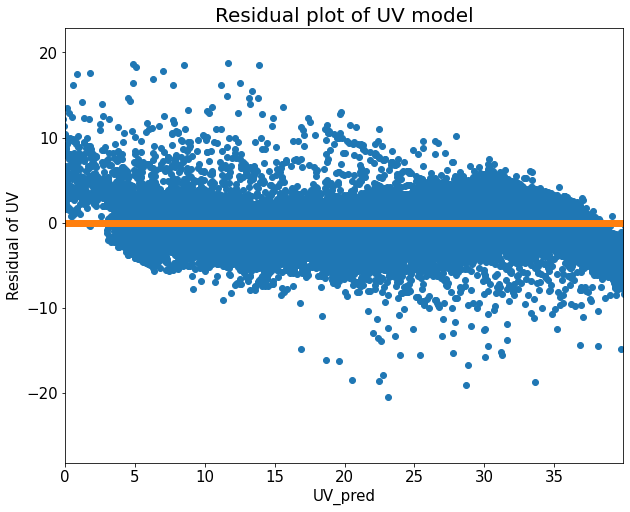

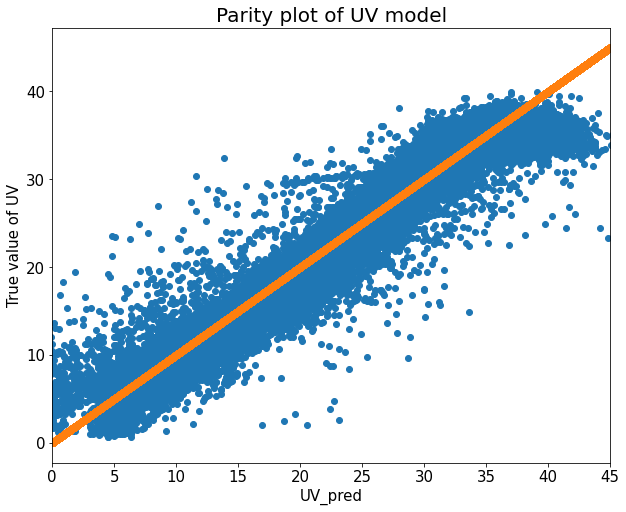

In [107]:
preds_UV, test_UV = opt_model(lr(), 'UV', data_trans, features_name, 0.4, 2, cv = True)
res_plot(np.array(preds_UV), np.array(test_UV), 'UV')
parity_plot(np.array(preds_UV), np.array(test_UV), 'UV')

From the visualization of this step, one can found that some patterns are not captured by the model. As a rough three-order polynomial relationship occurs between the residual and predictions of UV in the residual plot, one possible way is to use polynomial regression to fit the data to predict UV.

### Summery of the MLR model for UV prediction
**Information of the optimal model:**
1. Data tranformation should be conducted as the first step.
1. All features should be included.
1. Linear regression and Ridge perform the best. For the simplicity of the model, linear regression is selected.
1. The optimal train/test ratio is 4/6.
1. Cross validation can help to increase the performance and the optimal k is 2 without data shuffling. When the data is shuffled, the optimal k cannot be determined.
**Evaludation of the model:**

The optimal model for UV prediction achieves the r2 score of about 0.940 and mse score of about 5.581. However, from the residual plot and parity plot, one can found that there are still some patterns that was not captured by the optimal model. One possible solution is to use polynomial regression as a pattern of polynomial curve occurs in the residual plot.

### Step 7. Polynomial regression for UV prediction

In [108]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit_transform(data_trans[features_name])
data_poly = poly.transform(data_trans[features_name])

In [109]:
data_poly.shape

(88426, 36)

In [110]:
data_poly = pd.DataFrame(data = data_poly)
data_poly['UV'] = data_trans['UV'].to_numpy()
print_nan(['UV'], data_poly)

  Nan of UV: 0


In [111]:
data_poly[data_poly.columns[:36]].head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,-0.424744,525.369111,9.587199,0.801511,1.140392,2.517696,2.360854,0.180407,-223.147117,...,0.642419,0.914037,2.017960,1.892250,1.300495,2.871162,2.692300,6.338796,5.943914,5.573632
1,1.0,-0.643791,446.816621,10.955062,0.728529,1.060540,2.128232,1.987874,0.414467,-287.656414,...,0.530754,0.772634,1.550478,1.448224,1.124746,2.257076,2.108221,4.529370,4.230657,3.951644
2,1.0,-0.550708,483.015349,10.512508,0.782923,1.091038,2.433613,2.302585,0.303279,-266.000202,...,0.612968,0.854198,1.905332,1.802747,1.190363,2.655164,2.512207,5.922474,5.603602,5.301898
3,1.0,-0.504766,422.409449,9.492389,0.764564,1.106454,2.785011,2.388763,0.254789,-213.217875,...,0.584557,0.845954,2.129318,1.826361,1.224240,3.081486,2.643056,7.756288,6.652731,5.706188
4,1.0,-0.514172,429.726026,9.682874,0.782923,1.100688,2.791165,2.501436,0.264373,-220.953060,...,0.612968,0.861754,2.185267,1.958432,1.211513,3.072201,2.753299,7.790603,6.981921,6.257182


In [112]:
train_poly, test_poly = train_test_split(data_poly, train_size = 0.8, random_state=42)
model = lr().fit(train_poly[data_poly.columns[:36]], train_poly['UV'])

r2_train_poly = model.score(train_poly[data_poly.columns[:36]], train_poly['UV'])
r2_test_poly = model.score(test_poly[data_poly.columns[:36]], test_poly['UV'])

mse_train_poly = mean_squared_error(train_poly['UV'], model.predict(train_poly[data_poly.columns[:36]]), squared = False)
mse_test_poly = mean_squared_error(test_poly['UV'], model.predict(test_poly[data_poly.columns[:36]]), squared = False)
    
matrices_poly = np.array([[r2_train_poly, r2_test_poly], [mse_train_poly, mse_test_poly]])
marices_poly_pd = pd.DataFrame(data = matrices_poly, index = ['r2', 'MSE'], columns = ['train', 'test'])

In [113]:
marices_poly_pd

,train,test
r2,0.972794,0.970754
MSE,1.590801,1.638442


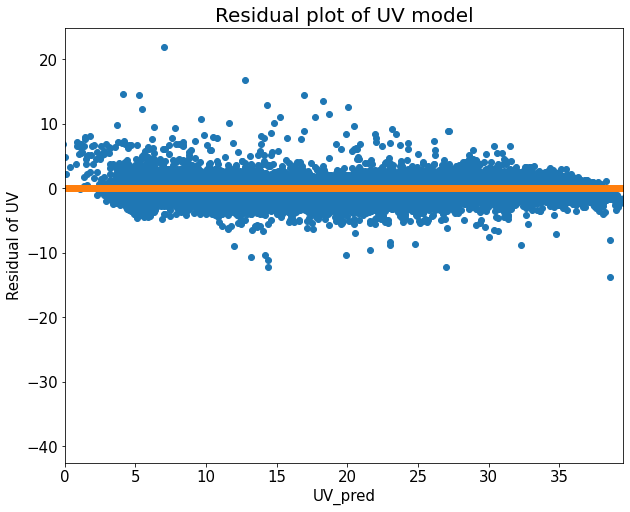

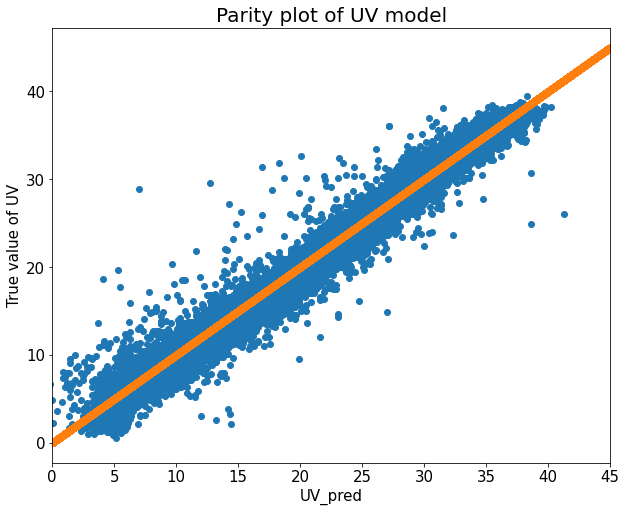

In [114]:
preds_UV_poly = model.predict(test_poly[data_poly.columns[:36]])
res_plot(np.array(preds_UV_poly), np.array(test_poly['UV']), 'UV')
parity_plot(np.array(preds_UV_poly), np.array(test_poly['UV']), 'UV')

**The second-order polynomial regression can effectively improve the model a lot.**

## 2.2 Model 2: Predicting UG by MLR

### Step 1. Data Transformation

In [115]:
# create an empty list to store the transformed average correlation coefficients
transformed_corrs_g = []

# Density
data_trans = data.copy()
data_trans['Density'] = -np.log(data_trans['Density'])
val1 = np.corrcoef(data_trans['Density'],data['UG'])[0][1]
transformed_corrs_g.append(val1)

# GSA
data_trans['GSA'] = data_trans['GSA']**2.5
val2 = np.corrcoef(data_trans['GSA'],data['UG'])[0][1]
transformed_corrs_g.append(val2)

# VSA
data_trans['VSA'] = np.log(data_trans['VSA'])
val3 = np.corrcoef(data_trans['VSA'],data['UG'])[0][1]
transformed_corrs_g.append(val3)

# VF
data_trans['VF'] = (data_trans['VF'])**8.5
val4 = np.corrcoef(data_trans['VF'],data['UG'])[0][1]
transformed_corrs_g.append(val4)

# PV
data_trans['PV'] = (data_trans['PV'])**0.6
val5 = np.corrcoef(data_trans['PV'],data['UG'])[0][1]
transformed_corrs_g.append(val5)

# LCD
#data_trans['LCD'] = data_trans['LCD']
val6 = np.corrcoef(data_trans['LCD'],data['UG'])[0][1]
transformed_corrs_g.append(val6)

# PLD
data_trans['PLD'] = data_trans['PLD']**0.6
val7 = np.corrcoef(data_trans['PLD'],data['UG'])[0][1]
transformed_corrs_g.append(val7)

In [116]:
df_rs['Transformed_UG_corr'] = transformed_corrs_g
df_rs

,UV,UG,Transformed_UV_corr,Transformed_UG_corr
Density,-0.859583,-0.767001,0.873311,0.941237
GSA,0.879612,0.832184,0.894125,0.891482
VSA,0.531110,0.082389,0.548980,0.093137
VF,0.931427,0.793706,0.944659,0.973805
PV,0.531742,0.933681,0.867419,0.988387
LCD,0.598184,0.828274,0.727839,0.828274
PLD,0.616528,0.825909,0.789985,0.837341


### Step 2. Tunning the features
* Can the transformed data help to improve the performance of MLR model?
* What is the best combination of features?

In [117]:
r2s_train, r2s_test, rmses_train, rmses_test = feature_tun_single(imp_UG_r2, data, 'UV', lr())
#print(rmses_test)

r2s_train_trans, r2s_test_trans, rmses_train_trans, rmses_test_trans = feature_tun_single(imp_UG_r2, data_trans, 'UV', lr())
#print(rmses_test_trans)

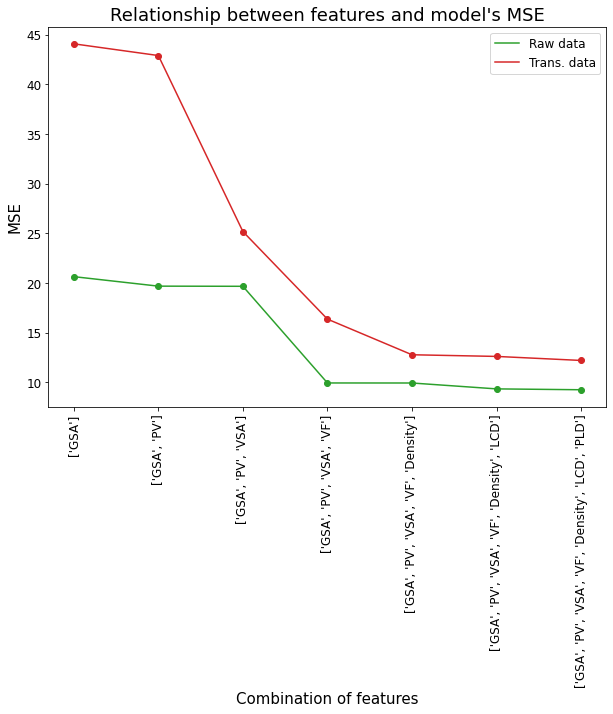

In [118]:
# get combinations of features
feature_comb = []
for i in range(1, len(imp_UG_r2)+1):
    feature_comb.append(imp_UG_r2[:i])

plt.figure(figsize = (10, 7))
plt.plot(np.linspace(1, 7, 7), rmses_test, color='tab:green')
plt.scatter(np.linspace(1, 7, 7), rmses_test, color='tab:green')
plt.plot(np.linspace(1, 7, 7), rmses_test_trans, color='tab:red')
plt.scatter(np.linspace(1, 7, 7), rmses_test_trans, color='tab:red')
plt.xlabel('Combination of features', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.title("Relationship between features and model's MSE", fontsize = 18)
plt.legend(['Raw data', 'Trans. data'], fontsize = 12)
plt.xticks(np.linspace(1, 7, 7), feature_comb, rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

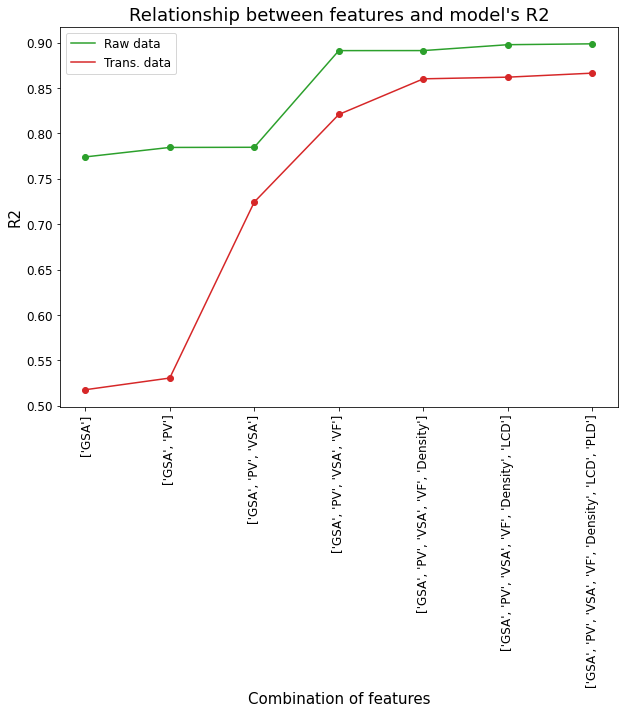

In [119]:
plt.figure(figsize = (10, 7))
plt.plot(np.linspace(1, 7, 7), r2s_test, color='tab:green')
plt.scatter(np.linspace(1, 7, 7), r2s_test, color='tab:green')
plt.plot(np.linspace(1, 7, 7), r2s_test_trans, color='tab:red')
plt.scatter(np.linspace(1, 7, 7), r2s_test_trans, color='tab:red')
plt.xlabel('Combination of features', fontsize = 15)
plt.ylabel('R2', fontsize = 15)
plt.title("Relationship between features and model's R2", fontsize = 18)
plt.legend(['Raw data', 'Trans. data'], fontsize = 12)
plt.xticks(np.linspace(1, 7, 7), feature_comb, rotation = 90, fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

From the 2 above plots, it can be concluded that transformed data can't help to enhance the performance of MLR model due to higher MSE score and lower R2 score. Therefore, the **raw data** will be used for the following steps.

### Step 3. Regularization

In [120]:
# linear regression
r2_train_lr, r2_test_lr, mse_train_lr, mse_test_lr = reg_method_single(data, lr(), 'UG', features_name)

# Ridge
r2_train_R, r2_test_R, mse_train_R, mse_test_R = reg_method_single(data, Ridge(), 'UG', features_name)

# Lasso
r2_train_L, r2_test_L, mse_train_L, mse_test_L = reg_method_single(data, Lasso(), 'UG', features_name)

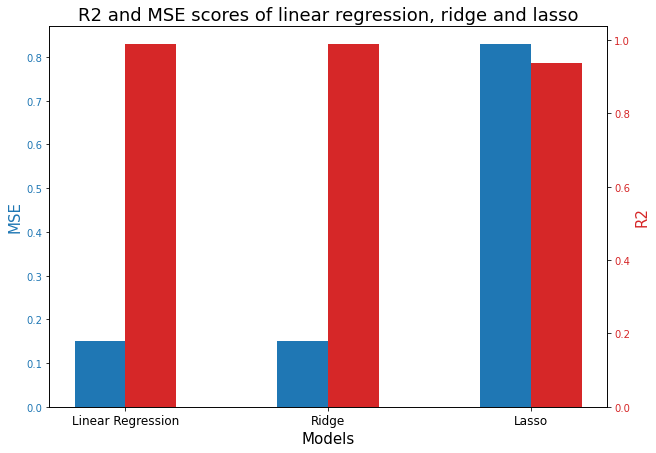

In [121]:
reg_r2_scores = [r2_test_lr, r2_test_R, r2_test_L]
reg_mse_scores = [mse_test_lr, mse_test_R, mse_test_L]
labels = ['Linear Regression', 'Ridge', 'Lasso']

x = np.arange(len(labels))
width = 0.25

fig, ax1 = plt.subplots(figsize = (10, 7))
ax1.bar(x - width/2, reg_mse_scores, width, label='MSE', color = 'tab:blue')

ax1.set_ylabel('MSE', color = 'tab:blue', fontsize = 15)
ax1.set_title('R2 and MSE scores of linear regression, ridge and lasso', fontsize = 18)
ax1.set_xlabel('Models', fontsize = 15)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize = 12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.bar(x + width/2, reg_r2_scores, width, label='R2', color = 'tab:red')
ax2.set_ylabel('R2', color = 'tab:red', fontsize = 15)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

The above analysis shows us that the linear regression and ridge model perform roughly the same while the lasso model performs much worse than the previous two models. **For the simplicity of the model, linear regression was selected.**

### Step 4. Optimal train/test ratio

In [122]:
assert(features_name == ['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD'])
train_test_ratios = np.linspace(0.1, 0.9, 9)

r2_train, r2_test, mse_train, mse_test = optimal_ratio_single(features_name, data, 'UG', lr())
print(max(r2_test))
print(min(mse_test))

0.9888436733729763
0.14028482246845264


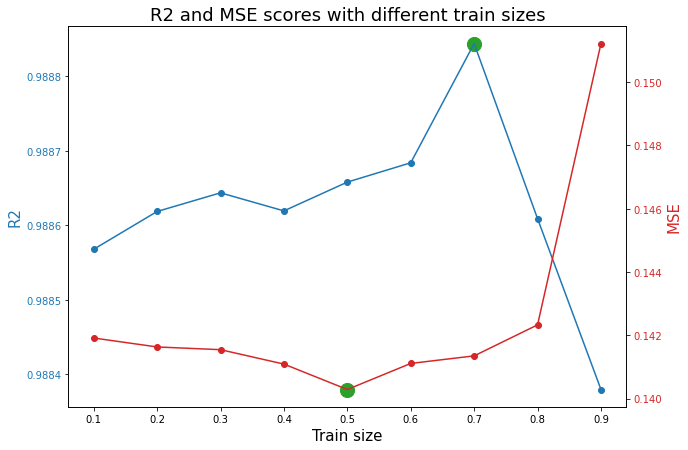

In [123]:
fig, ax1 = plt.subplots(figsize = (10, 7))

ax1.plot(train_test_ratios, r2_test, color = 'tab:blue')
ax1.scatter(train_test_ratios, r2_test, color = 'tab:blue')
plt.scatter(train_test_ratios[6], r2_test[6], color = 'tab:green', s = 200)
ax1.set_ylabel('R2', color = 'tab:blue', fontsize = 15)
ax1.set_title('R2 and MSE scores with different train sizes', fontsize = 18)
ax1.set_xlabel('Train size', fontsize = 15)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(train_test_ratios, mse_test, color = 'tab:red')
ax2.scatter(train_test_ratios, mse_test, color = 'tab:red')
plt.scatter(train_test_ratios[4], mse_test[4], color = 'tab:green', s = 200)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylabel('MSE', color = 'tab:red', fontsize = 15)
plt.show()

It is interesting to found that the maximum of R2 and the minimum of MSE doesn't occur in the same train size. However, comparing the points where train size is at 0.5 and 0.7, it can be found that the R2 score at 0.7 is much higher than that of 0.5 while the MSE score at 0.7 is only slightly higher than that of 0.5. **Therefore, the optimal train size is selected as 0.7.**

### Step 5. Cross Validation

In [124]:
mse_tests_UG, r2_tests_UG = CV(lr(), 'UG', data, features_name, 0.7, fold_number = np.linspace(2, 10, 9))
print("R2 for UG:")
print(max(r2_tests_UG))
print(r2_tests_UG.index(max(r2_tests_UG))+2)
print("MSE for UG:")
print(min(mse_tests_UG))
print(mse_tests_UG.index(min(mse_tests_UG))+2)

# compared the best CV model with the one without CV
print(max(r2_test) < r2_tests_UG[6])
print(min(mse_test) > mse_tests_UG[6])

R2 for UG:
0.9888440509966385
3
MSE for UG:
0.14134309416104332
3
True
False


Though the model with cross validation has higher value of r2_test compared to the one without cross validation, its mse value is also higher. Therefore, it can be estimated that the model with cross validation doesn't help improve the performance comprehensively and it performs roughly the same as the one without cross validation. **Therefore, for the simplicity of the model, the MLR model without cross validation was selected.**

### Step 6. Optimized Model Investigation

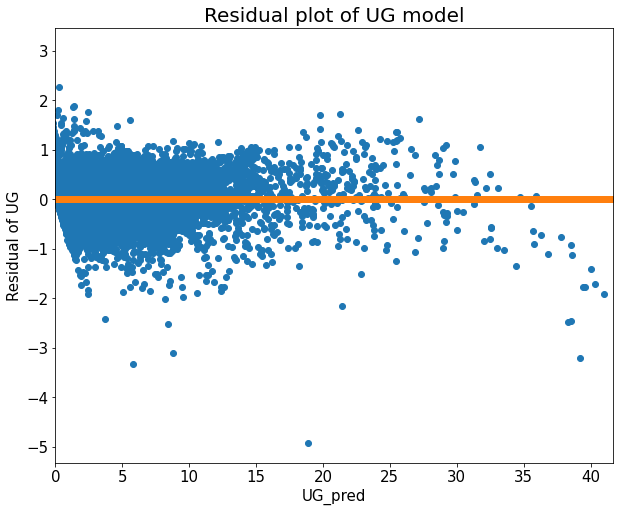

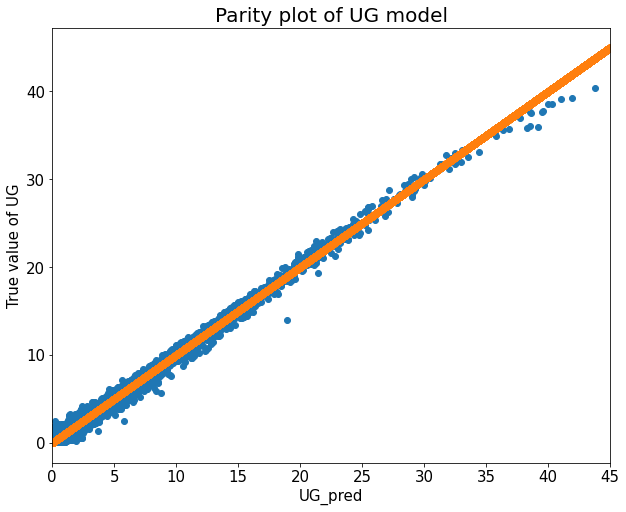

In [125]:
preds_UG, test_UG = opt_model(lr(), 'UG', data, features_name, 0.7, 2, cv = False)
res_plot(np.array(preds_UG), np.array(test_UG), 'UG')
parity_plot(np.array(preds_UG), np.array(test_UG), 'UG')

### Summery of the MLR model for UG prediction
**Information of the optimal model:**
1. Data tranformation shouldn't be conducted.
1. All features should be included.
1. Linear regression and Ridge perform the best. For the simplicity of the model, linear regression is selected.
1. The optimal train/test ratio is 7/3.
1. Cross validation can't help to increase the performance comprehensively. For the simplicity of the model, linear regression without cross validation is selected.
**Evaludation of the model:**

The optimal model for UG prediction achieves the r2 score of about 0.989 and mse score of about 0.141. From the residual plot and parity plot, one can found that the model almost capture the pattern but the optimized model failed to predict the response accurately when the UG is large.

# Part 3. Neural Network

The MLR models are able to predict UV and UG with high accuracy. However, the UG and UV are intrinsically correlated and both used to measure the hydrogen performance of MOFs. Additionally, they can all be predicted based on the same structural properties. Therefore, it is nature to think that how we can predict UG and UV simualtaneously. To achieve this goal, two neural networks were constructed and compared to the MLR models.

In [126]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [127]:
# load data
train, test = train_test_split(data, train_size = 0.8, random_state=42)

### Tunning the architecture of the neural network

In [128]:
# define the model
model_1 = Sequential([
      layers.Dense(2)
])
# compile the model
model_1.compile(loss = tf.losses.MeanSquaredError(),
                          optimizer = tf.optimizers.Adam())
# fit the model
model_1.fit(train[features_name], train[['UV', 'UG']], epochs=20)

Epoch 1/20
2211/2211 [==============================] - 3s 1ms/step - loss: 40470.0742
Epoch 2/20
2211/2211 [==============================] - 2s 1ms/step - loss: 18.4330
Epoch 3/20
2211/2211 [==============================] - 2s 1ms/step - loss: 13.7026
Epoch 4/20
2211/2211 [==============================] - 2s 1ms/step - loss: 10.8097
Epoch 5/20
2211/2211 [==============================] - 2s 997us/step - loss: 9.3094
Epoch 6/20
2211/2211 [==============================] - 2s 1ms/step - loss: 8.0012
Epoch 7/20
2211/2211 [==============================] - 2s 1ms/step - loss: 7.4536
Epoch 8/20
2211/2211 [==============================] - 2s 1ms/step - loss: 7.3536
Epoch 9/20
2211/2211 [==============================] - 2s 998us/step - loss: 7.2012
Epoch 10/20
2211/2211 [==============================] - 2s 995us/step - loss: 7.0032
Epoch 11/20
2211/2211 [==============================] - 2s 1ms/step - loss: 7.0150
Epoch 12/20
2211/2211 [==============================] - 2s 1ms/step - l

In [129]:
# get the predictions
UV_pred = []
UG_pred = []
preds = model_1.predict(test[features_name])
for i in range(len(preds)):
    UV_pred.append(preds[i][0])
    UG_pred.append(preds[i][1])

# calculate the matrices
r2_UV = r2_score(test['UV'], UV_pred)
r2_UG = r2_score(test['UG'], UG_pred)
mse_UV = mean_squared_error(test['UV'], UV_pred)
mse_UG = mean_squared_error(test['UG'], UG_pred)

display(pd.DataFrame(data = [[r2_UV, r2_UG], [mse_UV, mse_UG]], index = ['R2', 'MSE'], columns = ['UV', 'UG']))

,UV,UG
R2,0.795762,0.963860
MSE,18.746936,0.451546


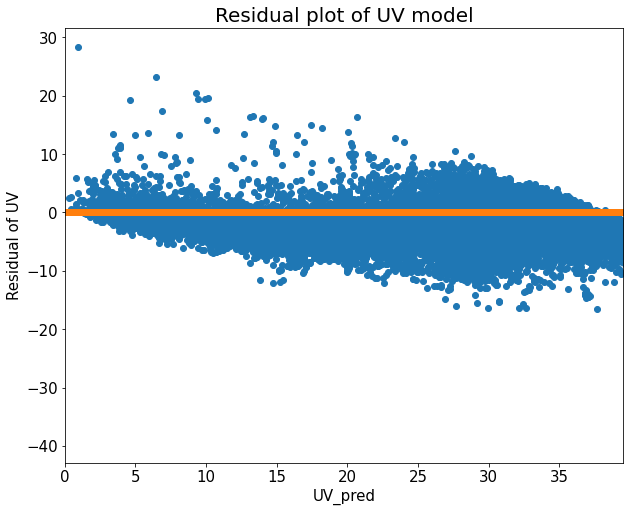

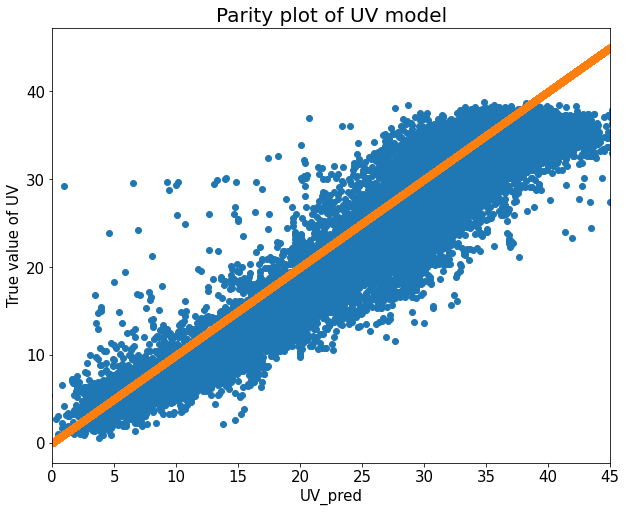

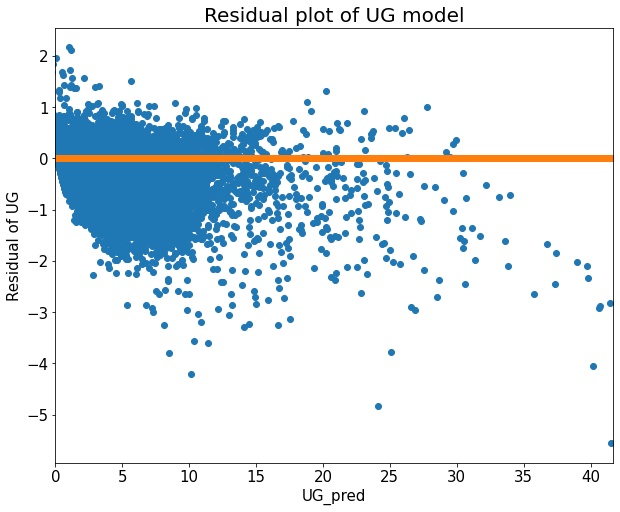

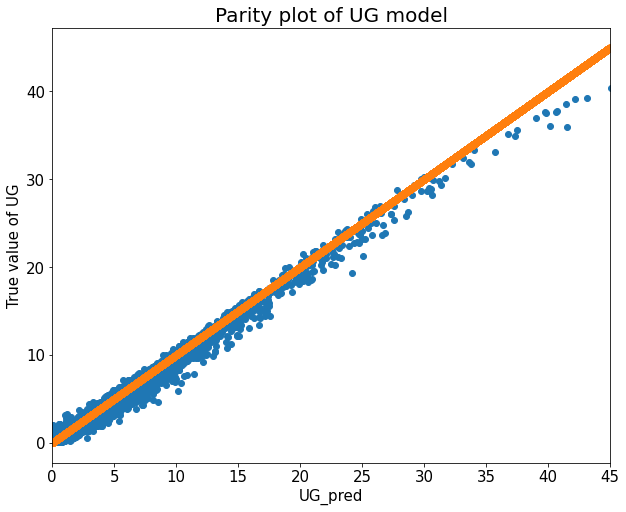

In [130]:
res_plot(np.array(UV_pred), np.array(test['UV']), 'UV')
parity_plot(np.array(UV_pred), np.array(test['UV']), 'UV')
res_plot(np.array(UG_pred), np.array(test['UG']), 'UG')
parity_plot(np.array(UG_pred), np.array(test['UG']), 'UG')

In [131]:
# define the model
model_2 = Sequential([
      layers.Dense(7),
      layers.Dense(2)
])
# compile the model
model_2.compile(loss = tf.losses.MeanSquaredError(),
                          optimizer = tf.optimizers.Adam())
# fit the model
model_2.fit(train[features_name], train[['UV', 'UG']], epochs=20)

Epoch 1/20
2211/2211 [==============================] - 3s 1ms/step - loss: 1471568.4332
Epoch 2/20
2211/2211 [==============================] - 2s 1ms/step - loss: 178.0891
Epoch 3/20
2211/2211 [==============================] - 2s 1ms/step - loss: 36.0153
Epoch 4/20
2211/2211 [==============================] - 3s 2ms/step - loss: 24.6093
Epoch 5/20
2211/2211 [==============================] - 3s 1ms/step - loss: 12.7313
Epoch 6/20
2211/2211 [==============================] - 3s 1ms/step - loss: 10.0332
Epoch 7/20
2211/2211 [==============================] - 3s 1ms/step - loss: 9.3737A
Epoch 8/20
2211/2211 [==============================] - 3s 2ms/step - loss: 9.1107
Epoch 9/20
2211/2211 [==============================] - 3s 1ms/step - loss: 8.5920
Epoch 10/20
2211/2211 [==============================] - 3s 2ms/step - loss: 8.2247
Epoch 11/20
2211/2211 [==============================] - 3s 1ms/step - loss: 8.6184
Epoch 12/20
2211/2211 [==============================] - 2s 1ms/step - l

In [132]:
# get the predictions
UV_pred = []
UG_pred = []
preds = model_2.predict(test[features_name])
for i in range(len(preds)):
    UV_pred.append(preds[i][0])
    UG_pred.append(preds[i][1])

# calculate the matrices
r2_UV = r2_score(test['UV'], UV_pred)
r2_UG = r2_score(test['UG'], UG_pred)
mse_UV = mean_squared_error(test['UV'], UV_pred)
mse_UG = mean_squared_error(test['UG'], UG_pred)

display(pd.DataFrame(data = [[r2_UV, r2_UG], [mse_UV, mse_UG]], index = ['R2', 'MSE'], columns = ['UV', 'UG']))

,UV,UG
R2,0.640782,0.975523
MSE,32.972470,0.305832


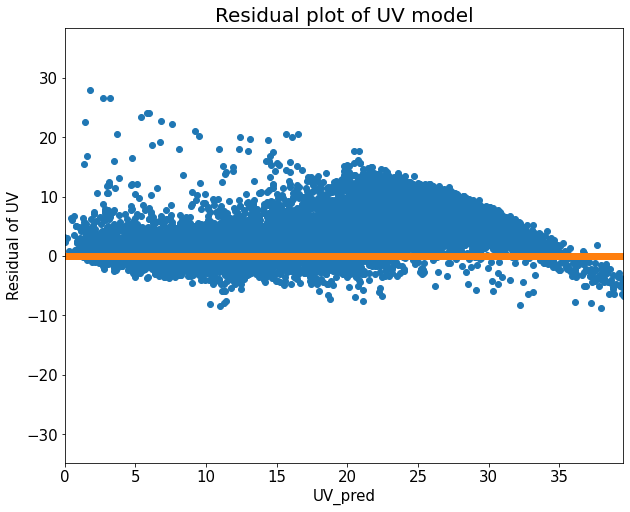

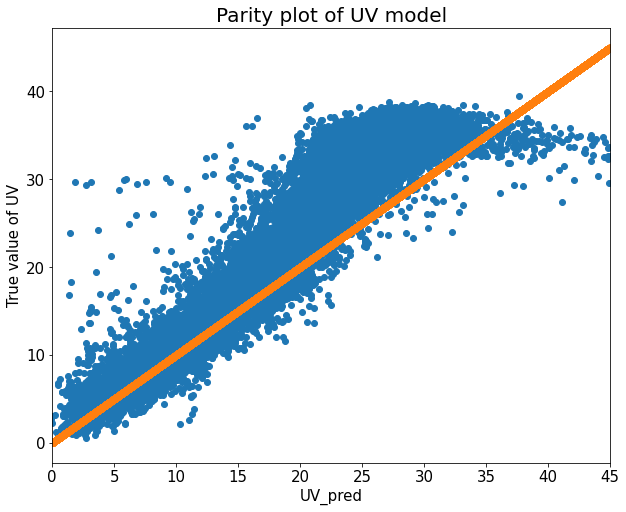

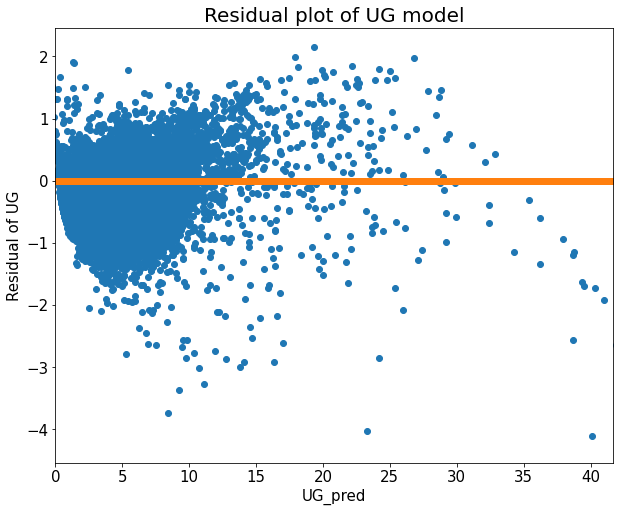

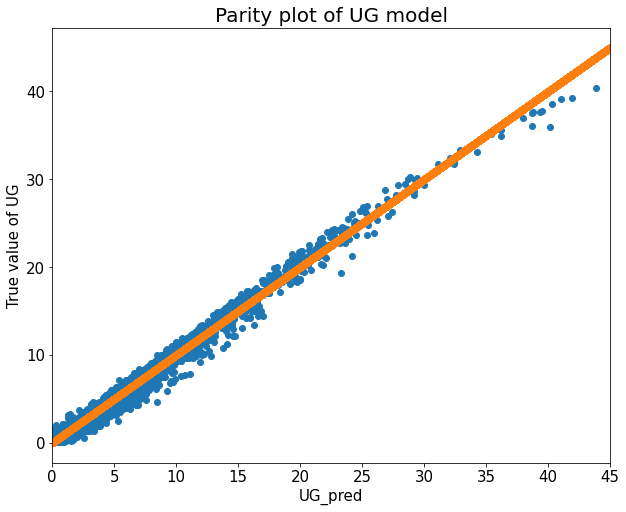

In [133]:
res_plot(np.array(UV_pred), np.array(test['UV']), 'UV')
parity_plot(np.array(UV_pred), np.array(test['UV']), 'UV')
res_plot(np.array(UG_pred), np.array(test['UG']), 'UG')
parity_plot(np.array(UG_pred), np.array(test['UG']), 'UG')

By comparing the two neural networks above with the optimal MLR models, one can found that both of the neural networks perform worse than the optimal MLR models. In terms of the two neural networks themselves, by simply adding a dense layer with 7 nodes can downplay the performance, which suggests the occurance of overfitting on the later neural network. Also, from the residual plots and parity plots, it can be found that some patterns were still not captured by the two neural networks. Thus, a model that suits the data is better than a complex model.